In [8]:
import numpy as np
import tensorflow as tf
from matplotlib import pylab as plt

In [4]:
data = np.load("burgers_data.npy")

In [5]:
data

array([[[ 1.00000000e+00,  1.10000000e+00,  1.20000000e+00, ...,
          2.80000000e+00,  2.90000000e+00,  3.00000000e+00],
        [ 9.00000000e-01,  9.90000000e-01,  1.08000000e+00, ...,
          2.52000000e+00,  2.61000000e+00,  2.70000000e+00],
        [ 8.18181818e-01,  9.00000000e-01,  9.81818182e-01, ...,
          2.29090909e+00,  2.37272727e+00,  2.45454545e+00],
        ...,
        [ 5.62500000e-01,  6.18750000e-01,  6.75000000e-01, ...,
          1.57500000e+00,  1.63125000e+00,  1.68750000e+00],
        [ 5.29411765e-01,  5.82352941e-01,  6.35294118e-01, ...,
          1.48235294e+00,  1.53529412e+00,  1.58823529e+00],
        [ 5.00000000e-01,  5.50000000e-01,  6.00000000e-01, ...,
          1.40000000e+00,  1.45000000e+00,  1.50000000e+00]],

       [[ 9.00000000e-01,  8.10000000e-01,  7.20000000e-01, ...,
         -7.20000000e-01, -8.10000000e-01, -9.00000000e-01],
        [ 1.00000000e+00,  9.00000000e-01,  8.00000000e-01, ...,
         -8.00000000e-01, -9.00000000e

In [7]:
Nsol,Nt,Nx = data.shape

In [10]:
data[5,0:2,:]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

This is the way of making the atomic stencil samples. This is the right idea, but let's pack it into the Conv1D framework to make it faster and easier to use.

In [34]:
Nsamp = Nsol*(Nt-1)*(Nx-2)
u_in = np.empty((Nsamp,3),dtype=np.float32)
u_out = np.empty((Nsamp,1),dtype=np.float32)
idx = 0
for i in range(Nsol):
    for j in range(Nt-1):
        for k in range(1,Nx-1):
            u_in[idx,:] = data[i,j,k-1:k+2]
            u_out[idx] = data[i,j+1,k]
            idx+=1

In [38]:
model = torch.nn.Sequential(
    torch.nn.Linear(3,20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1),
)
loss = torch.nn.MSELoss(reduction='sum')

So, let's remake the dataset that ties together frames

In [35]:
u_out

array([[0.99      ],
       [1.08      ],
       [1.17      ],
       ...,
       [0.9416199 ],
       [0.97082037],
       [0.99160796]], dtype=float32)

In [94]:
Nsamp = Nsol*(Nt-1)
u_in = np.empty((Nsamp,Nx),dtype=np.float32)
u_out = np.empty((Nsamp,Nx-2),dtype=np.float32)
idx = 0
for i in range(Nsol):
    for j in range(Nt-1):
        u_in[idx,:]=data[i,j,:]
        u_out[idx,:] = data[i,j+1,1:-1]
        idx+=1

In [37]:
import torch

In [69]:
model = torch.nn.Sequential(
    torch.nn.Conv1d(1,9,3),
    torch.nn.ReLU(),
    torch.nn.Conv1d(9,9,1),
    torch.nn.ReLU(),
    torch.nn.Conv1d(9,5,1),
    torch.nn.ReLU(),
    torch.nn.Conv1d(5,1,1)
)

In [95]:
to_u_in = torch.tensor(u_in).reshape((u_in.shape[0],1,u_in.shape[1]))
to_u_out = torch.tensor(u_out).reshape((u_out.shape[0],1,u_out.shape[1]))

In [96]:
loss(model(to_u_in),to_u_out)

tensor(3056.7429, grad_fn=<MseLossBackward>)

In [120]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(1000):
    y_pred = model(to_u_in)
    lo = loss(y_pred, to_u_out)
    if t % 100 == 99:
        print(t, lo.item())
    optimizer.zero_grad()
    lo.backward()
    optimizer.step()

99 137.59588623046875
199 136.8531951904297
299 136.1243133544922
399 135.4072723388672
499 134.69224548339844
599 133.95619201660156
699 133.24339294433594
799 132.54449462890625
899 131.85646057128906
999 131.17933654785156


In [128]:
def plot_model(i):
    with torch.no_grad():
        uN = model(to_u_in[i:i+1,:,:])
    plt.plot(uN.numpy().flatten())
    plt.plot(np.r_[[0],u_out[i,:],[0]])

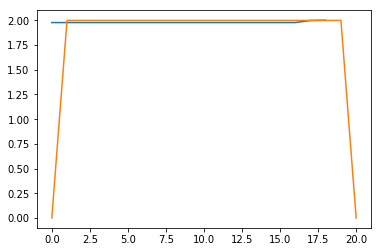

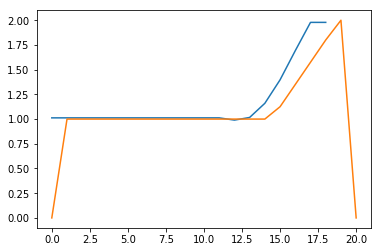

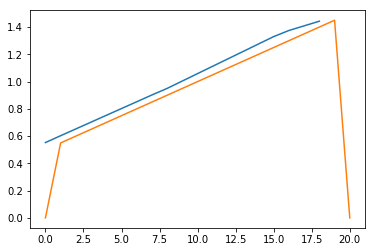

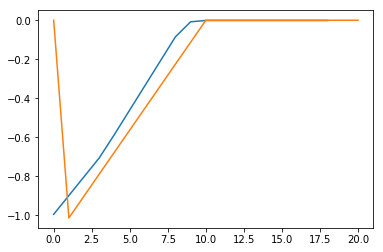

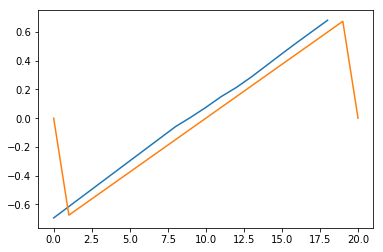

In [129]:
for i in range(5):
    s = np.random.randint(Nsamp)
    plt.figure()
    plot_model(s)

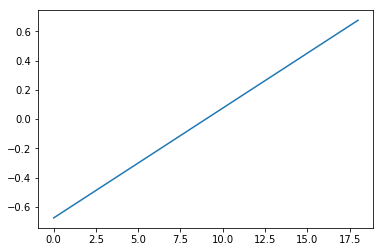

In [103]:
plt.plot(to_u_out[20:21,:,:].numpy().flatten())

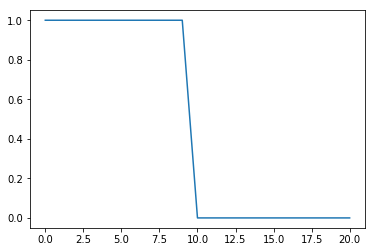

In [134]:
plt.plot(u0)

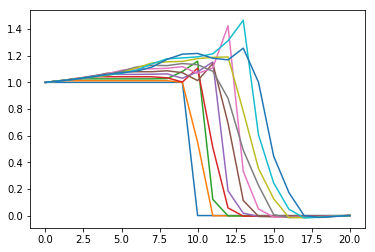

In [144]:
u0 = data[5:6,0:1,:]
u0 = torch.tensor(u0,dtype=torch.float32)
plt.plot(u0.numpy().flatten())
with torch.no_grad():
    for i in range(10):
        uN = model(u0)
        u0[0,0,1:-1] = uN
        plt.plot(u0.numpy().flatten())
